In [404]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [405]:
df = pd.read_csv("question4-stock-data.csv")
print(df.head())

   Unnamed: 0        Date  Adj Close     Close      High       Low      Open  \
0           0  1980-03-17   2.296798  3.291227  3.344743  3.291227  0.000000   
1           1  1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   
2           2  1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606   
3           3  1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000   
4           4  1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  


In [406]:
# Drop unnamed index columns from df
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
# Convert date column to date format
df.loc[:, 'Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [407]:
print(df.head())

                  Date  Adj Close     Close      High       Low      Open  \
0  1980-03-17 00:00:00   2.296798  3.291227  3.344743  3.291227  0.000000   
1  1980-03-18 00:00:00   2.306134  3.304606  3.358122  3.304606  0.000000   
2  1980-03-19 00:00:00   2.306134  3.304606  3.304606  3.304606  3.304606   
3  1980-03-20 00:00:00   2.306134  3.304606  3.358122  3.304606  0.000000   
4  1980-03-21 00:00:00   2.362154  3.384880  3.438396  3.384880  0.000000   

    Volume  
0  41109.0  
1   9343.0  
2      0.0  
3  10277.0  
4   8409.0  


In [408]:
print(len(df))

11291


In [409]:
print(df.describe())

          Adj Close         Close          High           Low          Open  \
count  11198.000000  11174.000000  11196.000000  11164.000000  11188.000000   
mean      63.609130     72.026945     72.503100     71.665079     67.999259   
std       52.266247     51.259828     51.550735     51.011632     55.834401   
min        2.259452      3.237711      3.237711      3.237711      0.000000   
25%       19.224636     27.500000     27.789255     27.536156      0.000000   
50%       50.608900     66.035000     66.724998     65.418751     66.065002   
75%      104.723621    114.297503    114.892500    113.639999    114.269997   
max      254.770004    254.770004    255.229996    253.589996    255.000000   

             Volume  
count  1.114600e+04  
mean   2.144157e+05  
std    3.883662e+05  
min    0.000000e+00  
25%    1.350000e+04  
50%    9.032350e+04  
75%    2.915750e+05  
max    1.858270e+07  


In [410]:
# the number of records with null values or 0 in dataset for each column
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")


'Date': Null values - 110, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 117, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 103, Zero values - 2948
'Volume': Null values - 145, Zero values - 131


Number of null-date records with exactly one day gap: 66
Number of null-date records with gap greater than one: 42
Number of unaccounted (leftover) null-date records: 2

=== Leftover null-date records (the 'missing 2') ===
     Date  Adj Close      Close       High        Low       Open    Volume
6125  NaT  61.361324  79.930000  80.669998  79.430000  80.440002  179700.0
6126  NaT  62.336311  81.199997  81.199997  79.900002  80.449997  327100.0


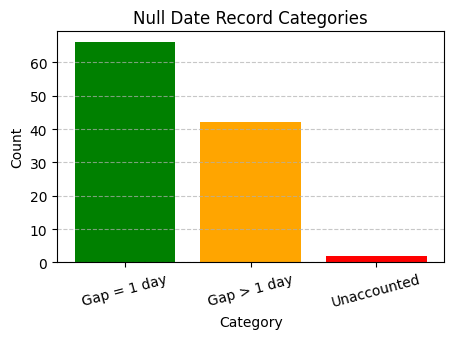

In [411]:
# Identify records with null Date
null_date_records = df[df['Date'].isnull()].copy()

# Counters
gap_one_count = 0
gap_greater_than_one_count = 0

# Dictionaries to store which rows belong to each category
fill_dict = {}           # key: index of the row, value: date to fill (for days_gap == 2)
unaccounted_indexes = [] # indices that don't fit days_gap == 2 or days_gap > 2

for idx in null_date_records.index:
    # If there's no valid previous or next row, it's automatically unaccounted
    if idx <= 0 or idx >= len(df) - 1:
        unaccounted_indexes.append(idx)
        continue

    date_before = df.loc[idx - 1, 'Date']
    date_after  = df.loc[idx + 1, 'Date']

    # If either side is null, we can't fill
    if pd.isnull(date_before) or pd.isnull(date_after):
        unaccounted_indexes.append(idx)
        continue

    # Calculate the gap
    days_gap = (date_after - date_before).days

    if days_gap == 2:
        # There's exactly 1 day in-between
        missing_day = date_before + pd.Timedelta(days=1)
        fill_dict[idx] = missing_day
        gap_one_count += 1
    elif days_gap > 2:
        gap_greater_than_one_count += 1
    else:
        # E.g., days_gap == 1 or days_gap < 2
        unaccounted_indexes.append(idx)

print(f"Number of null-date records with exactly one day gap: {gap_one_count}")
print(f"Number of null-date records with gap greater than one: {gap_greater_than_one_count}")
print(f"Number of unaccounted (leftover) null-date records: {len(unaccounted_indexes)}")

# Actually fill the single-day-gap rows
for row_idx, new_date in fill_dict.items():
    df.loc[row_idx, 'Date'] = new_date

# Print the leftover records
if len(unaccounted_indexes) > 0:
    print("\n=== Leftover null-date records (the 'missing 2') ===")
    print(df.loc[unaccounted_indexes].to_string(index=True))

# Plot the counts in a small figure
plt.figure(figsize=(5, 3))
plt.bar(
    ["Gap = 1 day", "Gap > 1 day", "Unaccounted"],
    [gap_one_count, gap_greater_than_one_count, len(unaccounted_indexes)],
    color=["green", "orange", "red"]
)
plt.xlabel("Category")
plt.ylabel("Count")
plt.title("Null Date Record Categories")
plt.xticks(rotation=15)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [412]:
# Print null and zero counts for 'Date' column
null_count = df['Date'].isnull().sum()
zero_count = (df['Date'] == 0).sum()  # Not typically needed for dates

print(f"'Date': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 44, Zero values - 0


In [413]:
# the number of records with null values or 0 in dataset for each column
# Assuming df is your DataFrame
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 44, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 117, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 103, Zero values - 2948
'Volume': Null values - 145, Zero values - 131


In [414]:
# Create a temporary DataFrame to check for adjacent nulls
temp_df = pd.DataFrame()

# Identify nulls in the 'Date' column
temp_df['IsNull'] = df['Date'].isnull()

# Check for consecutive null values
temp_df['PrevNull'] = temp_df['IsNull'].shift(1, fill_value=False)
temp_df['NextNull'] = temp_df['IsNull'].shift(-1, fill_value=False)

# Determine rows with adjacent nulls
temp_df['AdjacentNulls'] = temp_df['IsNull'] & (temp_df['PrevNull'] | temp_df['NextNull'])

# Get indices where adjacent nulls exist
adjacent_null_indices = temp_df.index[temp_df['AdjacentNulls']].tolist()

# Print the indices
print("Indices with adjacent nulls in the 'Date' column:", adjacent_null_indices)

Indices with adjacent nulls in the 'Date' column: [6125, 6126]


In [415]:
# the region around index 6124-6127
start_check = 6123
end_check = 6128
print("\nSample region after filling:\n")
print(df.loc[start_check:end_check, ['Date','Close','Adj Close']].to_string(index=True))


Sample region after filling:

                     Date      Close  Adj Close
6123  2004-06-18 00:00:00  79.300003  60.877697
6124  2004-06-21 00:00:00  80.430000  61.745182
6125                  NaT  79.930000  61.361324
6126                  NaT  81.199997  62.336311
6127  2004-06-24 00:00:00        NaN  62.013870
6128  2004-06-25 00:00:00  79.760002  61.230824


In [416]:
# fill the date of record after record with 2004-06-18 anf the record after that with 2004-06-22
if 6125 in unaccounted_indexes:
    df.loc[6125, 'Date'] = pd.to_datetime('2004-06-22')
if 6126 in unaccounted_indexes:
    df.loc[6126, 'Date'] = pd.to_datetime('2004-06-23')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [417]:
# Show the region around index 6124-6127
start_check = 6123
end_check = 6128
print("\nSample region after filling:\n")
print(df.loc[start_check:end_check, ['Date','Close','Adj Close']].to_string(index=True))

# Printing null and zero counts for 'Date' column after dropping nulls
null_count = df['Date'].isnull().sum()
zero_count = (df['Date'] == 0).sum()
print(f"\n'Date': Null values - {null_count}, Zero values - {zero_count}")


Sample region after filling:

           Date      Close  Adj Close
6123 2004-06-18  79.300003  60.877697
6124 2004-06-21  80.430000  61.745182
6125 2004-06-22  79.930000  61.361324
6126 2004-06-23  81.199997  62.336311
6127 2004-06-24        NaN  62.013870
6128 2004-06-25  79.760002  61.230824

'Date': Null values - 42, Zero values - 0


In [418]:
df = df.dropna(subset=['Date']).reset_index(drop=True)
# Print null and zero counts for 'Date' column after dropping nulls
null_count = df['Date'].isnull().sum()
zero_count = (df['Date'] == 0).sum()
print(f"'Date': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 0, Zero values - 0


In [419]:
df['Year'] = df['Date'].dt.year

In [420]:
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,Year
0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0,1980
1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0,1980
2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0,1980
3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0,1980
4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0,1980


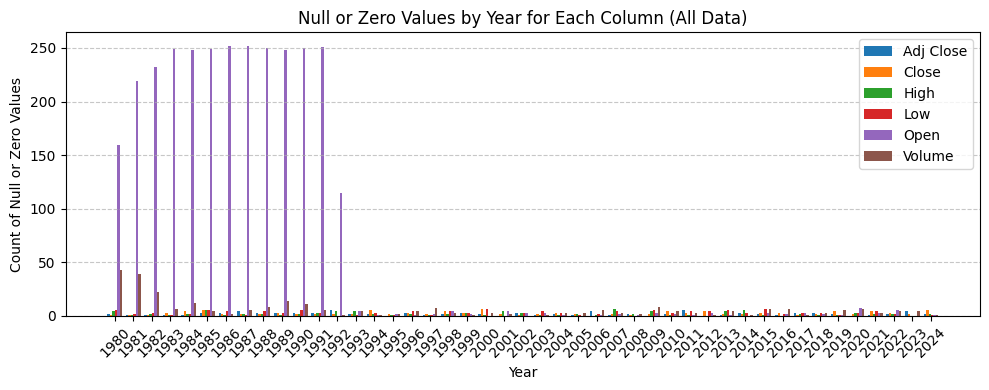

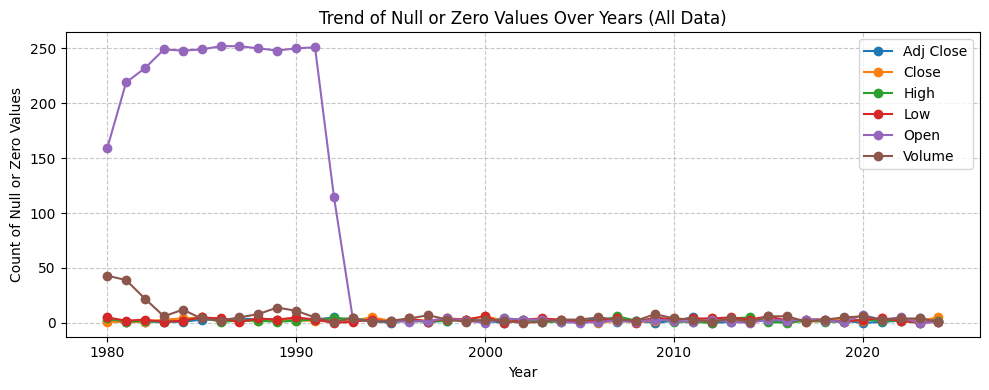

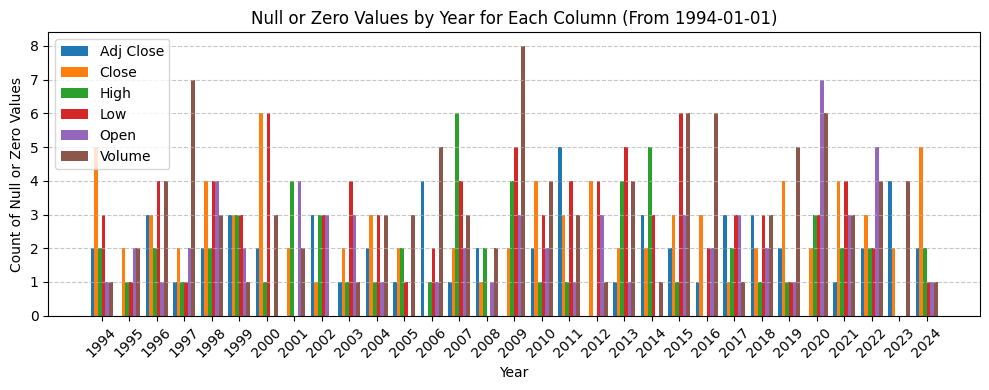

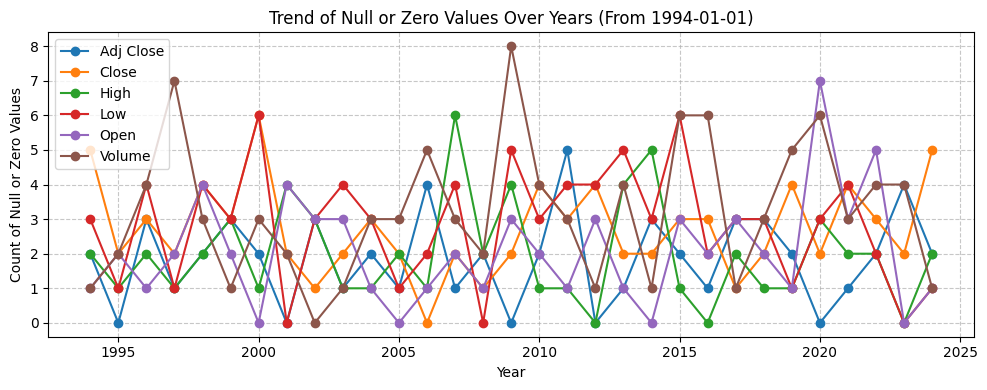

In [421]:
def analyze_null_zero_values(df, start_date=None, title_suffix=""):
    # Filter data if start_date is provided
    if start_date:
        df = df[df['Date'] >= pd.to_datetime(start_date)]

    years = sorted(df['Year'].unique())

    # Get all column names except 'Date' and 'Year'
    value_columns = [col for col in df.columns if col not in ['Date', 'Year']]

    counts_by_column = {}

    for col in value_columns:
        counts_by_column[col] = []

    # Count null or zero values for each year and each column
    for year in years:
        # Filter data for the current year
        year_data = df[df['Year'] == year]

        # For each value column, count nulls or zeros
        for col in value_columns:
            null_or_zero_count = (year_data[col].isna() | (year_data[col] == 0)).sum()
            counts_by_column[col].append(null_or_zero_count)

    counts_df = pd.DataFrame({'Year': years})
    for col in value_columns:
        counts_df[f'{col}_null_or_zero'] = counts_by_column[col]

    # Plot the results - Bar Chart
    plt.figure(figsize=(10, 4))

    # Calculate bar width based on number of columns
    bar_width = 0.8 / len(value_columns)
    offset = np.linspace(-0.4 + bar_width/2, 0.4 - bar_width/2, len(value_columns))

    # Plot bars for each column
    for i, col in enumerate(value_columns):
        plt.bar(
            x=np.arange(len(years)) + offset[i],
            height=counts_df[f'{col}_null_or_zero'],
            width=bar_width,
            label=col
        )

    # Set x-axis ticks and labels
    plt.xticks(np.arange(len(years)), years, rotation=45)

    # Add labels and title
    plt.xlabel('Year')
    plt.ylabel('Count of Null or Zero Values')
    plt.title(f'Null or Zero Values by Year for Each Column{title_suffix}')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

    # Line Chart for Trend Analysis
    plt.figure(figsize=(10, 4))

    # Plot line for each column
    for col in value_columns:
        plt.plot(counts_df['Year'], counts_df[f'{col}_null_or_zero'], marker='o', label=col)

    plt.xlabel('Year')
    plt.ylabel('Count of Null or Zero Values')
    plt.title(f'Trend of Null or Zero Values Over Years{title_suffix}')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    file_prefix = 'null_zero_trend' if not start_date else f'null_zero_trend_from_{start_date.replace("-", "_")}'
    plt.savefig(f'{file_prefix}_by_year.png')
    plt.show()

    return counts_df


all_data_counts = analyze_null_zero_values(df, title_suffix=" (All Data)")

# For data from 1999-06-06 onwards
filtered_data_counts = analyze_null_zero_values(df, start_date='1994-01-01', title_suffix=" (From 1994-01-01)")

In [422]:
# filter out records after 1994-01-01. save it in data.csv

# Filter out records after 1994-01-01
filtered_df = df[df['Date'] >= pd.to_datetime('1994-01-01')]

# Save the filtered data to a new CSV file
filtered_df.to_csv('data.csv', index=False)


In [423]:
# the number of records with null values or 0 in dataset for each column
for col in df.columns:
    null_count = df[col].isnull().sum()
    zero_count = (df[col] == 0).sum()
    print(f"'{col}': Null values - {null_count}, Zero values - {zero_count}")

'Date': Null values - 0, Zero values - 0
'Adj Close': Null values - 93, Zero values - 0
'Close': Null values - 116, Zero values - 0
'High': Null values - 95, Zero values - 0
'Low': Null values - 127, Zero values - 0
'Open': Null values - 102, Zero values - 2940
'Volume': Null values - 145, Zero values - 131
'Year': Null values - 0, Zero values - 0


In [424]:
# 2. Create columns for previous day Adj Close and Close
df['Adj_Close_prev'] = df['Adj Close'].shift(1)
df['Close_prev'] = df['Close'].shift(1)
df['Date_prev'] = df['Date'].shift(1)

In [425]:
df = df.iloc[1:]
# Now df contains all rows except the first one
print(df.head())


        Date  Adj Close     Close      High       Low      Open   Volume  \
1 1980-03-18   2.306134  3.304606  3.358122  3.304606  0.000000   9343.0   
2 1980-03-19   2.306134  3.304606  3.304606  3.304606  3.304606      0.0   
3 1980-03-20   2.306134  3.304606  3.358122  3.304606  0.000000  10277.0   
4 1980-03-21   2.362154  3.384880  3.438396  3.384880  0.000000   8409.0   
5 1980-03-24   2.371490  3.398259  3.451775  3.398259  0.000000   2803.0   

   Year  Adj_Close_prev  Close_prev  Date_prev  
1  1980        2.296798    3.291227 1980-03-17  
2  1980        2.306134    3.304606 1980-03-18  
3  1980        2.306134    3.304606 1980-03-19  
4  1980        2.306134    3.304606 1980-03-20  
5  1980        2.362154    3.384880 1980-03-21  


In [426]:
filtered_df = df[(df['Close'].notnull()) & (df['Adj Close'].notnull()) & (df['Close'] != 0) & (df['Adj Close'] != 0)]
filtered_df = filtered_df.copy()
filtered_df.loc[:, 'Close_AdjClose_Diff'] = filtered_df['Close'] - filtered_df['Adj Close']

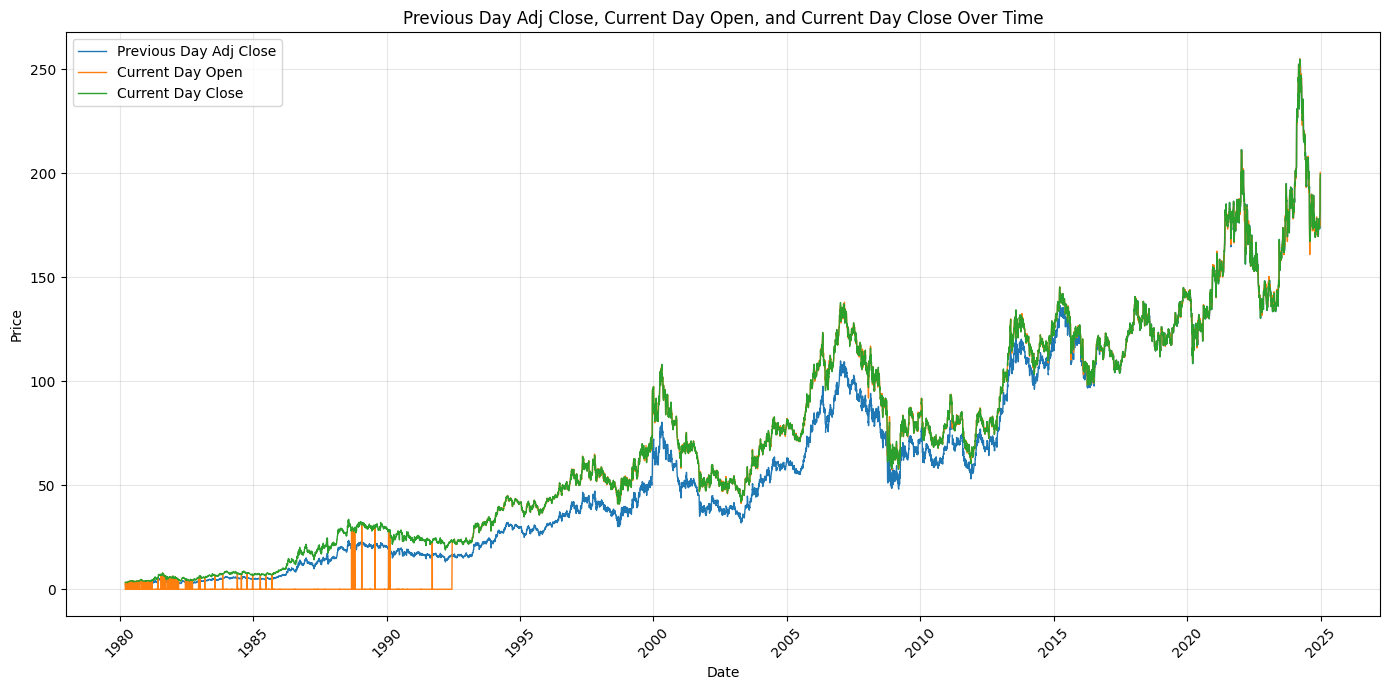

In [427]:
# Create a time series plot
plt.figure(figsize=(14, 7))

# Plot all three series
plt.plot(df['Date'], df['Adj_Close_prev'], label='Previous Day Adj Close', linewidth=1)
plt.plot(df['Date'], df['Open'], label='Current Day Open', linewidth=1)
plt.plot(df['Date'], df['Close'], label='Current Day Close', linewidth=1)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Previous Day Adj Close, Current Day Open, and Current Day Close Over Time')
plt.legend()
plt.grid(True, alpha=0.3)

# Format the x-axis date ticks
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

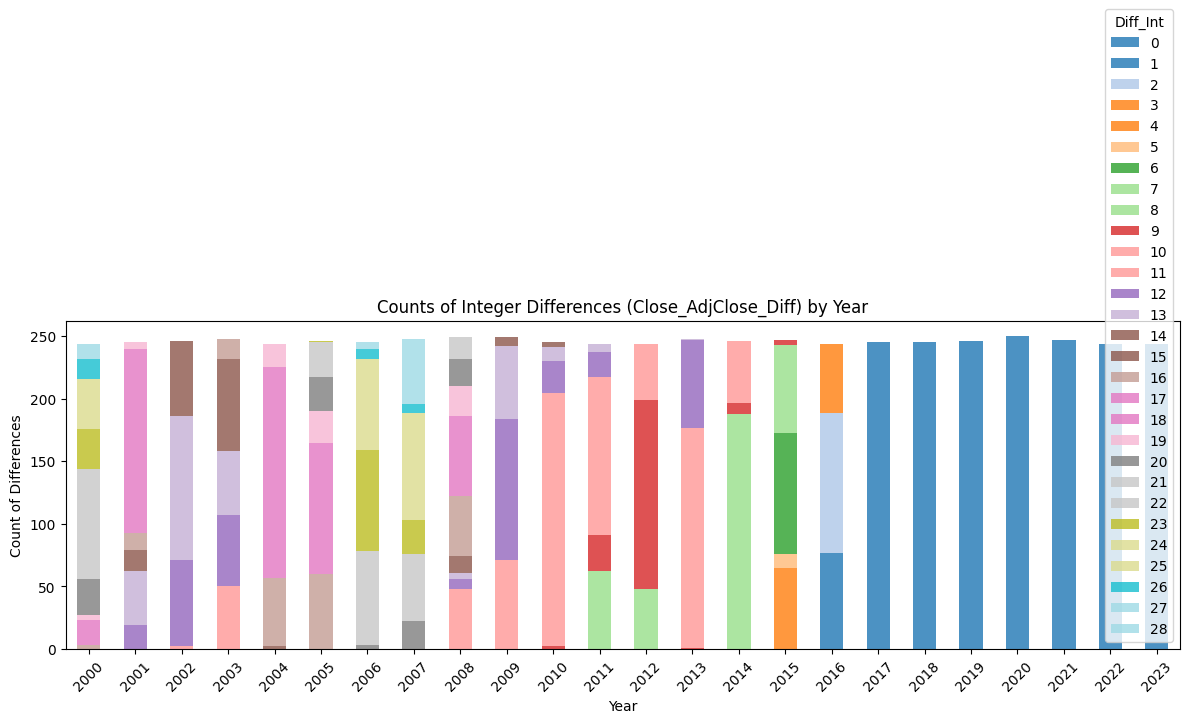

In [428]:
def plot_difference_counts_by_year(df, diff_column='Close_AdjClose_Diff', start_year=2000, end_year=None):
    """
    Plots a bar chart showing the counts of integer differences (Close - Adj Close) by year.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing 'Date' and the specified 'diff_column' columns.
    diff_column : str, default 'Close_AdjClose_Diff'
        The column containing the differences to analyze.
    start_year : int, default 2000
        The first year to include in the analysis.
    end_year : int, optional
        The last year to include in the analysis. Defaults to the latest year in the DataFrame.
    """

    # filter by start and end year
    if end_year is None:
        end_year = int(df['Year'].max())

    df_filtered = df[(df['Year'] >= start_year) & (df['Year'] <= end_year)].copy()

    # Round the differences to integers
    df_filtered['Diff_Int'] = df_filtered[diff_column].round().astype(int)

    # Get the count of each integer difference per year
    counts_by_year = df_filtered.groupby(['Year', 'Diff_Int']).size().unstack(fill_value=0)

    # Plot a stacked bar chart
    ax = counts_by_year.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 6),
        cmap='tab20',
        alpha=0.8
    )
    plt.xlabel('Year')
    plt.ylabel('Count of Differences')
    plt.title(f'Counts of Integer Differences ({diff_column}) by Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_difference_counts_by_year(filtered_df, diff_column='Close_AdjClose_Diff', start_year=2000, end_year=2023)


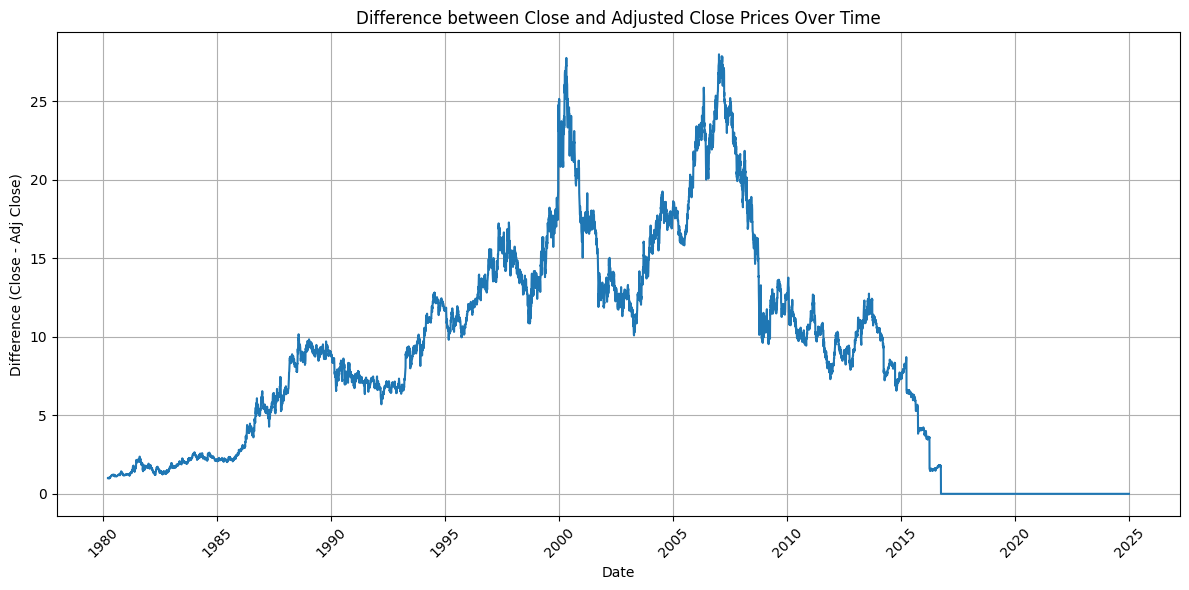

In [429]:
# plot how pre_adj close, open differed with time

# Visualize the difference of Close with Adj Close over time
plt.figure(figsize=(12, 6))
plt.plot(filtered_df['Date'], filtered_df['Close'] - filtered_df['Adj Close'])
plt.xlabel('Date')
plt.ylabel('Difference (Close - Adj Close)')
plt.title('Difference between Close and Adjusted Close Prices Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


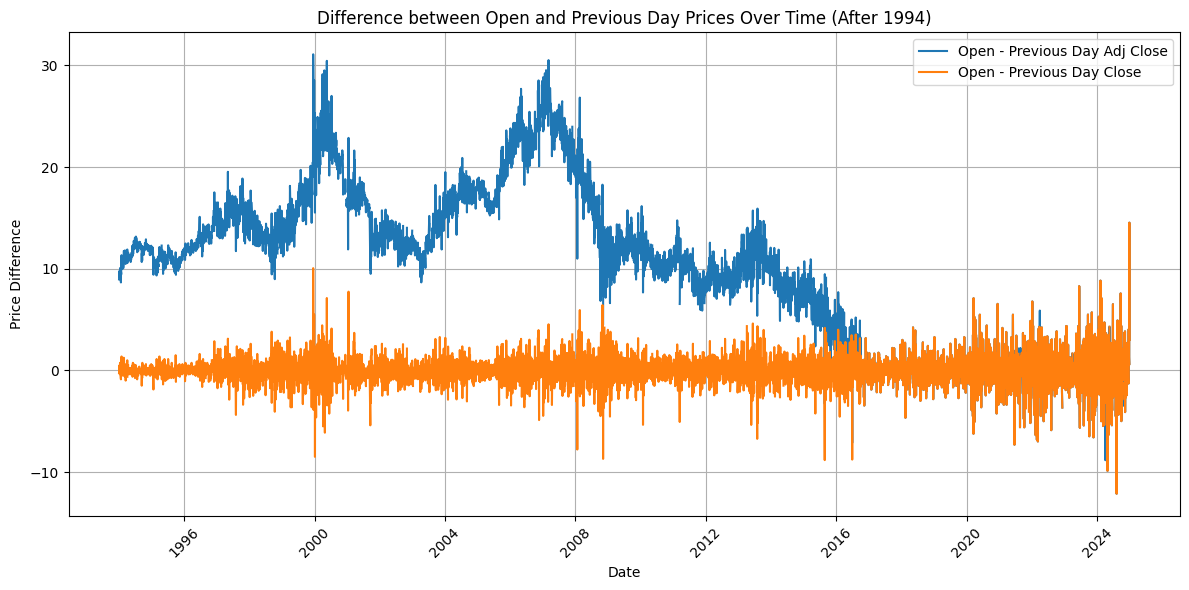

In [430]:
# to visualize the difference bwteen column open and adjusted close vaies with time
filtered_df['Open_AdjClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Adj_Close_prev']
filtered_df['Open_ClosePrev_Diff'] = filtered_df['Open'] - filtered_df['Close_prev']

# Filter data for dates after 2016
filtered_df_after_2016 = filtered_df[filtered_df['Date'] >= pd.to_datetime('1994-01-01')]

plt.figure(figsize=(12, 6))
plt.plot(filtered_df_after_2016['Date'], filtered_df_after_2016['Open_AdjClosePrev_Diff'], label='Open - Previous Day Adj Close')
plt.plot(filtered_df_after_2016['Date'], filtered_df_after_2016['Open_ClosePrev_Diff'], label='Open - Previous Day Close')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.title('Difference between Open and Previous Day Prices Over Time (After 1994)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [431]:
# Filter data for dates after 2017
filtered_df_after_2017 = filtered_df[filtered_df['Date'] >= pd.to_datetime('2017-01-01')]

# Calculate the difference between 'Open' and previous day's 'Adjusted Close'
filtered_df_after_2017['Open_AdjClosePrev_Diff'] = filtered_df_after_2017['Open'] - filtered_df_after_2017['Adj_Close_prev']

# Define the thresholds
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Count records based on the difference
for i in range(len(thresholds)):
    if i == 0:
        count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) == thresholds[i]])
        print(f"Number of records where |Open - Prev Adj Close| is equal to {thresholds[i]}: {count}")
    else:
        count = len(filtered_df_after_2017[(abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) > thresholds[i-1]) & (abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) <= thresholds[i])])
        print(f"Number of records where {thresholds[i-1]} < |Open - Prev Adj Close| <= {thresholds[i]}: {count}")

# Count records where the difference is greater than the last threshold
count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff']) > thresholds[-1]])
print(f"Number of records where |Open - Prev Adj Close| > {thresholds[-1]}: {count}")

Number of records where |Open - Prev Adj Close| is equal to 0: 25
Number of records where 0 < |Open - Prev Adj Close| <= 1: 1072
Number of records where 1 < |Open - Prev Adj Close| <= 2: 448
Number of records where 2 < |Open - Prev Adj Close| <= 3: 195
Number of records where 3 < |Open - Prev Adj Close| <= 4: 90
Number of records where 4 < |Open - Prev Adj Close| <= 5: 50
Number of records where 5 < |Open - Prev Adj Close| <= 10: 41
Number of records where 10 < |Open - Prev Adj Close| <= 15: 3
Number of records where |Open - Prev Adj Close| > 15: 0


<ipython-input-431-56ecb16d29ea>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_after_2017['Open_AdjClosePrev_Diff'] = filtered_df_after_2017['Open'] - filtered_df_after_2017['Adj_Close_prev']


In [432]:
def plot_open_adjclose_diff_distribution(
    df,
    start_year,
    end_year,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=None
):
    """
    Plots the distribution of abs(Open - Adj_Close_prev) by year, binned by specified thresholds.

    Parameters:
    -----------
    df : pd.DataFrame
        The DataFrame containing 'Date', 'Open', and 'Adj_Close_prev'.
    start_year : int
        The first year to include in the plot.
    end_year : int
        The last year to include in the plot.
    column_name : str, default 'Open_AdjClosePrev_Diff'
        The name of the column to store the difference (Open - Adj_Close_prev).
    thresholds : list, default [0, 1, 2, 3, 4, 5, 10, 15]
        The list of numeric cutoffs for binning the absolute difference.
        The first bin checks == thresholds[0].
        The subsequent bins are (thresholds[i-1], thresholds[i]].
        Finally, there's one bin for > thresholds[-1].
    """

    import numpy as np
    import matplotlib.pyplot as plt

    if thresholds is None:
        thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

    # Calculate the difference (Open - Adj_Close_prev) if not already calculated
    if column_name not in df.columns:
        df[column_name] = df['Open'] - df['Adj_Close_prev']
    else:
        # If it exists but needs updating, do so
        df[column_name] = df['Open'] - df['Adj_Close_prev']

    # Dictionary to store counts for each year: { year: [counts for each bin], ... }
    all_counts = {}

    # Loop through years in the specified range
    years_to_check = range(start_year, end_year + 1)
    for year in years_to_check:
        # Filter only the records for this specific year
        df_year = df[df['Date'].dt.year == year]

        # List to hold the bin counts in the order of thresholds
        counts_for_year = []

        # Bins:
        #   - bin #1: abs(difference) == 0
        #   - bin #2: abs(difference) in (0, 1]
        #   - bin #3: abs(difference) in (1, 2]
        #   ... up to your largest threshold
        for i in range(len(thresholds)):
            if i == 0:
                # Exactly == thresholds[0]
                count = len(df_year[abs(df_year[column_name]) == thresholds[i]])
            else:
                # (thresholds[i-1], thresholds[i]]
                count = len(df_year[
                    (abs(df_year[column_name]) > thresholds[i - 1]) &
                    (abs(df_year[column_name]) <= thresholds[i])
                ])
            counts_for_year.append(count)

        # Final bin: > thresholds[-1]
        count = len(df_year[abs(df_year[column_name]) > thresholds[-1]])
        counts_for_year.append(count)

        # Store the counts for this year
        all_counts[year] = counts_for_year

    # Prepare labels for the bins
    threshold_labels = (
        [f"=={thresholds[0]}"] +
        [f"({thresholds[i-1]}, {thresholds[i]}]" for i in range(1, len(thresholds))] +
        [f">{thresholds[-1]}"]
    )

    # Create the bar chart
    bar_width = 0.15
    x_positions = np.arange(len(threshold_labels))

    fig, ax = plt.subplots(figsize=(20, 6))
    sorted_years = sorted(all_counts.keys())

    for i, year in enumerate(sorted_years):
        ax.bar(
            x_positions + i * bar_width,
            all_counts[year],
            width=bar_width,
            label=str(year)
        )

    ax.set_xticks(x_positions + (len(sorted_years) - 1) * bar_width / 2)
    ax.set_xticklabels(threshold_labels)
    ax.set_xlabel('Absolute Price Difference Bins')
    ax.set_ylabel('Number of Records')
    ax.set_title('Distribution of Differences of Open and Adj_Close_prev by Year')
    ax.legend()
    plt.tight_layout()
    plt.show()


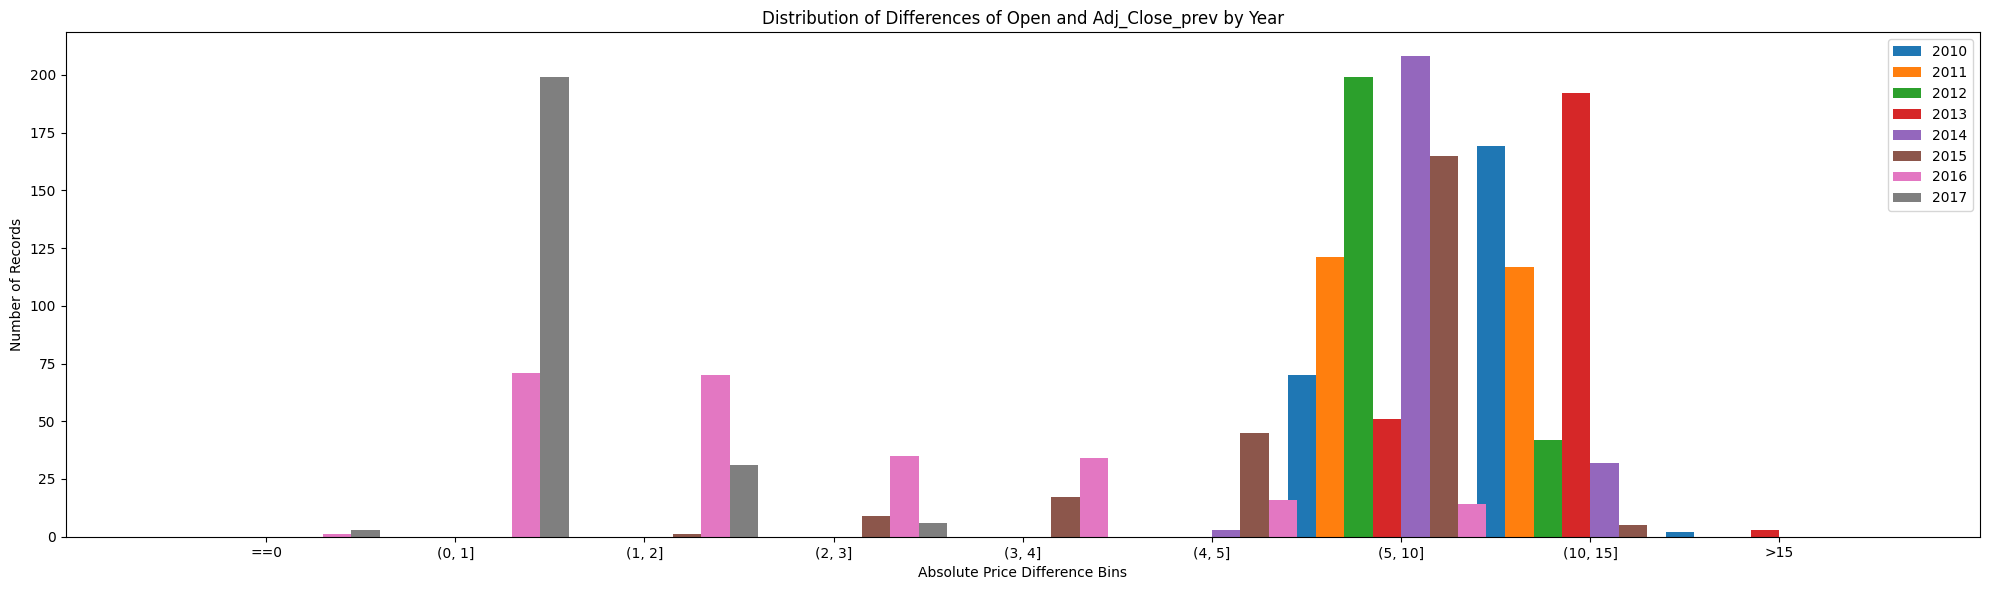

In [433]:
plot_open_adjclose_diff_distribution(
    df=filtered_df,
    start_year=2010,
    end_year=2017,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=[0, 1, 2, 3, 4, 5, 10, 15]
)


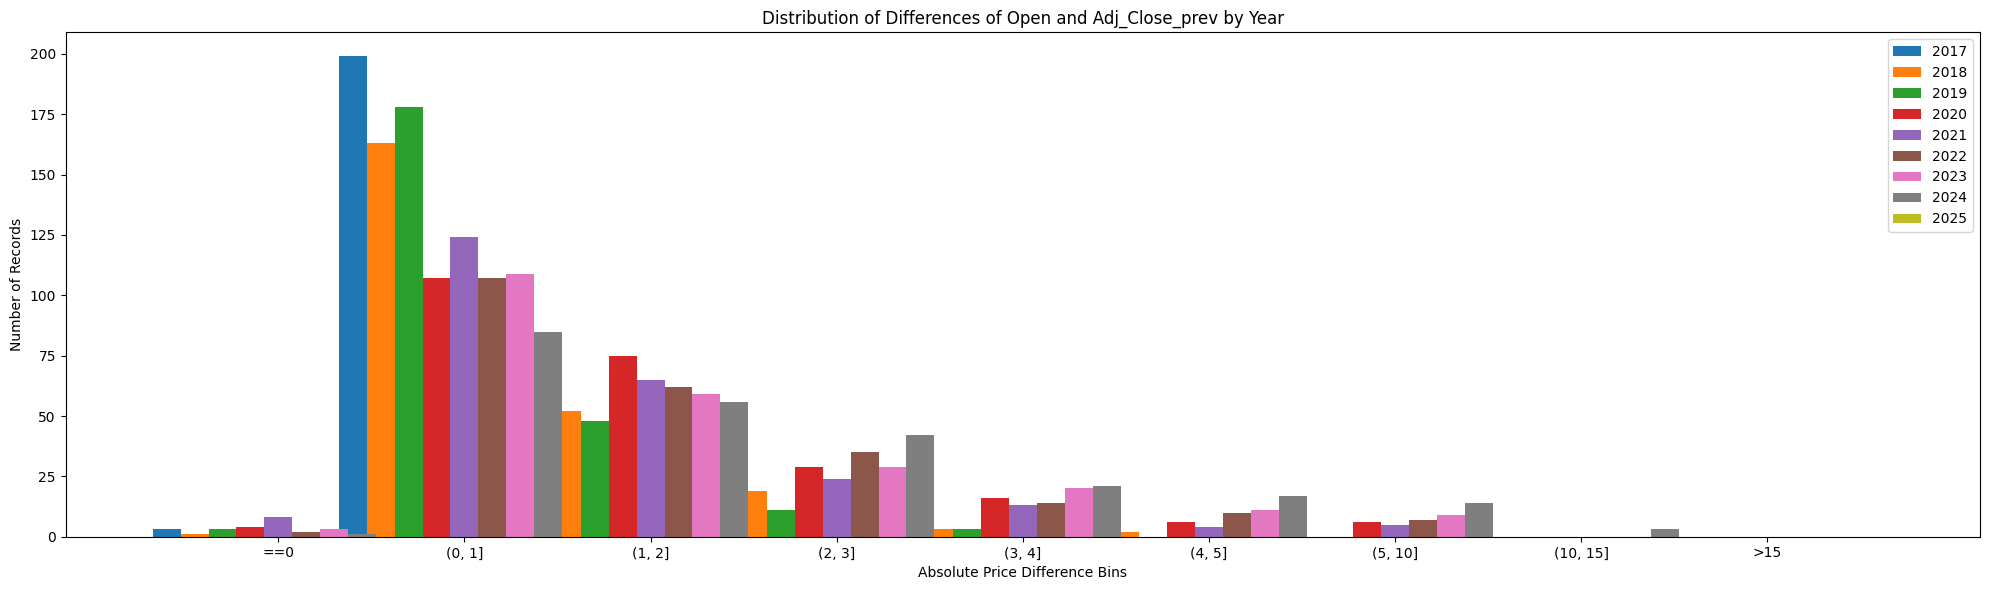

In [434]:
plot_open_adjclose_diff_distribution(
    df=filtered_df,
    start_year=2017,
    end_year=2025,
    column_name='Open_AdjClosePrev_Diff',
    thresholds=[0, 1, 2, 3, 4, 5, 10, 15]
)

In [435]:
# Group data by year and count the number of records
record_counts_by_year = filtered_df.groupby(filtered_df['Date'].dt.year).size()

# Filter record counts for years after 2020
record_counts_after_2020 = record_counts_by_year[record_counts_by_year.index > 2017]

# Print the record counts after 2020
print(record_counts_after_2020)

Date
2018    245
2019    246
2020    250
2021    247
2022    244
2023    244
2024    242
dtype: int64


In [436]:
# Filter data for dates after 2017
filtered_df_after_2017 = filtered_df[filtered_df['Date'] >= pd.to_datetime('2017-01-01')]

# Calculate the difference between 'Open' and previous day's 'Adjusted Close'
filtered_df_after_2017.loc[:, 'Open_AdjClosePrev_Diff'] = filtered_df_after_2017['Open'] - filtered_df_after_2017['Adj_Close_prev']

# Calculate the percentage difference relative to previous day's 'Adjusted Close'
filtered_df_after_2017.loc[:, 'Open_AdjClosePrev_Diff_Pct'] = (filtered_df_after_2017['Open_AdjClosePrev_Diff'] / filtered_df_after_2017['Adj_Close_prev']) * 100

# Define the thresholds (now in percentage)
thresholds = [0, 1, 2, 3, 4, 5, 10, 15]

# Count records based on the percentage difference
for i in range(len(thresholds)):
    if i == 0:
        count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) == thresholds[i]])
        print(f"Number of records where |Open - Prev Adj Close| is equal to {thresholds[i]}%: {count}")
    else:
        count = len(filtered_df_after_2017[(abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) > thresholds[i-1]) & (abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) <= thresholds[i])])
        print(f"Number of records where {thresholds[i-1]}% < |Open - Prev Adj Close| <= {thresholds[i]}%: {count}")

# Count records where the percentage difference is greater than the last threshold
count = len(filtered_df_after_2017[abs(filtered_df_after_2017['Open_AdjClosePrev_Diff_Pct']) > thresholds[-1]])
print(f"Number of records where |Open - Prev Adj Close| > {thresholds[-1]}%: {count}")

Number of records where |Open - Prev Adj Close| is equal to 0%: 25
Number of records where 0% < |Open - Prev Adj Close| <= 1%: 1335
Number of records where 1% < |Open - Prev Adj Close| <= 2%: 405
Number of records where 2% < |Open - Prev Adj Close| <= 3%: 114
Number of records where 3% < |Open - Prev Adj Close| <= 4%: 28
Number of records where 4% < |Open - Prev Adj Close| <= 5%: 11
Number of records where 5% < |Open - Prev Adj Close| <= 10%: 6
Number of records where 10% < |Open - Prev Adj Close| <= 15%: 0
Number of records where |Open - Prev Adj Close| > 15%: 0


<ipython-input-436-f9bd56859995>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_after_2017.loc[:, 'Open_AdjClosePrev_Diff_Pct'] = (filtered_df_after_2017['Open_AdjClosePrev_Diff'] / filtered_df_after_2017['Adj_Close_prev']) * 100


In [437]:
def plot_integer_differences_for_year(df, year, diff_col_name='Open_AdjClosePrev_Diff'):
    """
    Plots a bar chart showing the integer counts of (Open - Adj_Close_prev) for a single year.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing at least 'Date', 'Open', and 'Adj_Close_prev' columns.
        Assumes df['Date'] is already in datetime format.
    year : int
        The year of interest (e.g., 2022).
    diff_col_name : str, optional
        Column name to store the difference (default 'Open_AdjClosePrev_Diff').
    """

    # 1. Filter data to the specific year
    df_year = df[df['Date'].dt.year == year].copy()

    # 2. Calculate the difference (Open - Adj_Close_prev) if not already present
    if diff_col_name not in df_year.columns:
        df_year[diff_col_name] = df_year['Open'] - df_year['Adj_Close_prev']
    else:
        df_year[diff_col_name] = df_year['Open'] - df_year['Adj_Close_prev']

    # 3. Identify problematic rows before conversion
    problematic_rows = df_year[
        ~np.isfinite(df_year[diff_col_name]) | df_year[diff_col_name].isnull()
    ]

    if not problematic_rows.empty:
        print(f"\nFound {len(problematic_rows)} problematic records in {year}:")
        print(problematic_rows[['Date', 'Open', 'Adj_Close_prev', diff_col_name]].to_string(index=True))

    # 4. Handle non-finite values (NaN, inf) before converting to integer
    df_year[diff_col_name] = df_year[diff_col_name].replace([np.inf, -np.inf], np.nan)
    df_year[diff_col_name] = df_year[diff_col_name].fillna(0)  # Replace NaNs with 0 (or another value)

    # 5. Convert the difference to integer
    df_year[diff_col_name] = df_year[diff_col_name].round().astype(int)

    # 6. Count the occurrences of each integer difference
    difference_counts = df_year[diff_col_name].value_counts().sort_index()

    # 7. Plot the integer difference counts
    difference_counts.plot(
        kind='bar',
        figsize=(6, 3),
        title=f'Integer Differences (Open - Adj_Close_prev) in {year}',
        xlabel='Difference (Integer)',
        ylabel='Count of Records'
    )
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



Found 5 problematic records in 2015:
           Date   Open  Adj_Close_prev  Open_AdjClosePrev_Diff
8770 2015-02-06    NaN      123.845696                     NaN
8803 2015-03-26  143.0             NaN                     NaN
8844 2015-05-26    NaN      131.790237                     NaN
8918 2015-09-09    NaN      115.600121                     NaN
8983 2015-12-10  125.0             NaN                     NaN


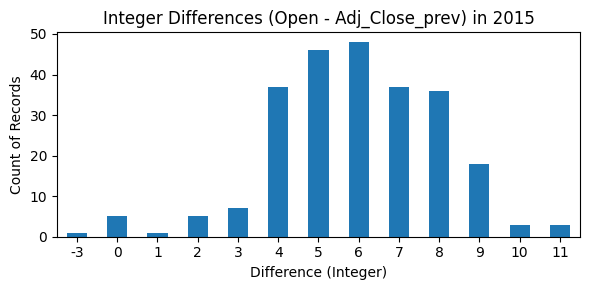

In [438]:
plot_integer_differences_for_year(filtered_df, 2015)


Found 3 problematic records in 2016:
           Date        Open  Adj_Close_prev  Open_AdjClosePrev_Diff
9049 2016-03-18  106.279999             NaN                     NaN
9203 2016-10-28         NaN      114.849998                     NaN
9219 2016-11-21         NaN      114.040001                     NaN


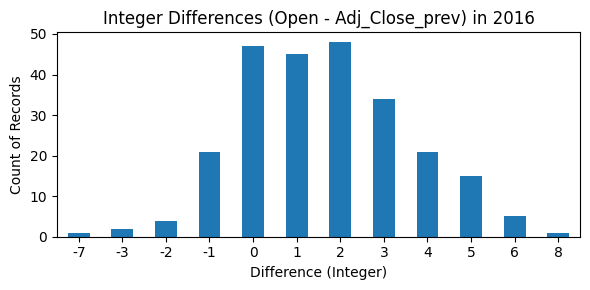

In [439]:
plot_integer_differences_for_year(filtered_df, 2016)


Found 6 problematic records in 2017:
           Date        Open  Adj_Close_prev  Open_AdjClosePrev_Diff
9315 2017-04-12         NaN      106.400002                     NaN
9325 2017-04-27  109.800003             NaN                     NaN
9373 2017-07-06  108.070000             NaN                     NaN
9421 2017-09-13         NaN      116.540001                     NaN
9444 2017-10-16         NaN      123.379997                     NaN
9483 2017-12-13  124.730003             NaN                     NaN


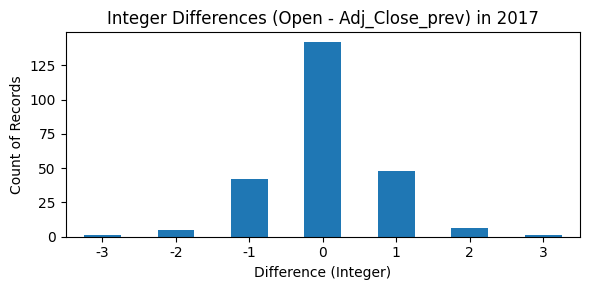

In [440]:
plot_integer_differences_for_year(filtered_df, 2017)

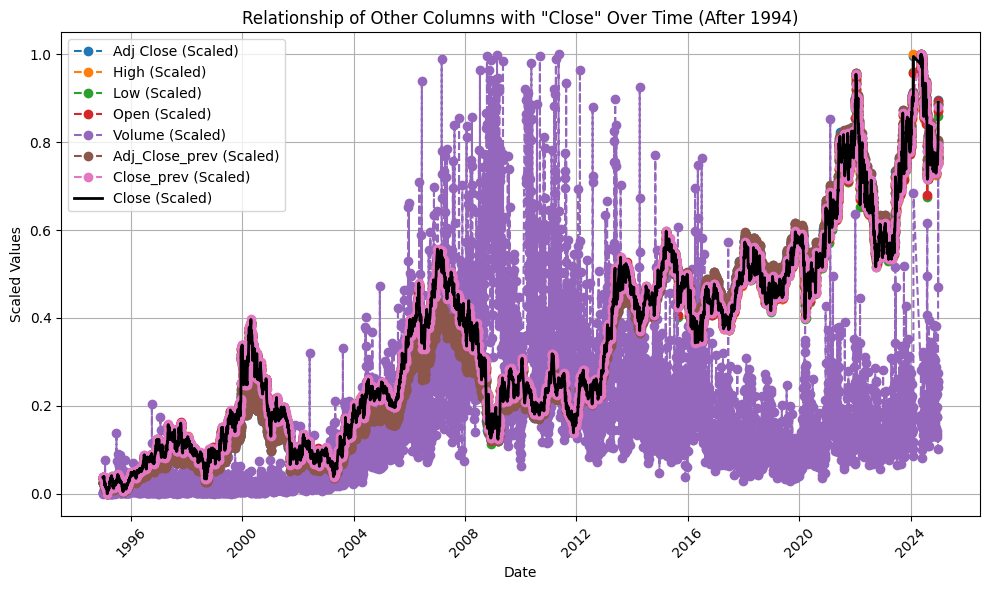

In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Filter data for dates after 1994 and drop rows with any null or empty values
cleaned_df = df[df['Date'].dt.year > 1994].dropna().reset_index(drop=True)

# Drop the 'Year' column if it exists
if 'Year' in cleaned_df.columns:
    cleaned_df = cleaned_df.drop(columns=['Year'])

# Identify and remove outliers using the Z-score method
z_scores = np.abs((cleaned_df.select_dtypes(include=[np.number]) - cleaned_df.select_dtypes(include=[np.number]).mean()) / cleaned_df.select_dtypes(include=[np.number]).std())
outlier_threshold = 3  # Z-score threshold for outliers
cleaned_df = cleaned_df[(z_scores < outlier_threshold).all(axis=1)]

# Ensure only numerical columns are selected for scaling
numerical_columns = cleaned_df.select_dtypes(include=[np.number]).columns

# Scale the data using Min-Max scaling only on numerical columns
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(cleaned_df[numerical_columns])

# Create a scaled DataFrame with the scaled values and retain the Date column separately
scaled_df = pd.DataFrame(scaled_values, columns=numerical_columns)
scaled_df['Date'] = cleaned_df['Date'].reset_index(drop=True)

# Plot the scaled values over time, focusing on the relationship with 'Close'
plt.figure(figsize=(10, 6))

for column in scaled_df.columns:
    if column != 'Close' and column != 'Date':
        plt.plot(scaled_df['Date'], scaled_df[column], label=f'{column} (Scaled)', marker='o', linestyle='--')

# Add the 'Close' column as a reference
plt.plot(scaled_df['Date'], scaled_df['Close'], label='Close (Scaled)', color='black', linewidth=2)

plt.xlabel('Date')
plt.ylabel('Scaled Values')
plt.title('Relationship of Other Columns with "Close" Over Time (After 1994)')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
